# Vector store

In [8]:
#!pip uninstall -y -q gensim
!pip install -q gensim

In [9]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import KeyedVectors
import heapq
from collections import defaultdict, namedtuple
import numpy as np # we mneed numpy 1.26.4
from numpy import float32 as FLOAT_TYPE



In [ ]:
# 1. Parameters
VECTOR_SIZE = 500
WINDOW      = 5
MIN_COUNT   = 5
WORKERS     = 4
MAX_WORDS_IN_BATCH = 1000

### CustomLineSentence

In [11]:
import itertools
from gensim import utils

class CustomLineSentence:
    def __init__(self, source):
        self.source = source

    def __iter__(self):
        """Iterate through the lines in the source."""
        with utils.open(self.source, 'rb') as fin:
            for line in itertools.islice(fin, None):
                line = utils.to_unicode(line).split()
                i = 0
                while i < len(line):
                    yield line[i: i + MAX_WORDS_IN_BATCH]
                    i += MAX_WORDS_IN_BATCH


In [12]:
# 2. Load the text8 corpus as a stream of sentences
sentences = CustomLineSentence('data/text8')

print("Number of sentences:", len(list(sentences)))

Number of sentences: 17006


In [13]:
print("Type of 'sentences':", type(sentences))
print("What we got from 'sentences':")
for i, s in enumerate(itertools.islice(sentences, 3)):
    print(f"Sentence {i+1}:", s)

    print("Length of sentence:", len(s))
    


Type of 'sentences': <class '__main__.CustomLineSentence'>
What we got from 'sentences':
Sentence 1: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 

In [14]:
# limit to the first 100 sentences for downstream processing
sentences = list(sentences)[:100]
print("Number of sentences in subset:", len(sentences))

Number of sentences in subset: 100


## Custom Doc2Vec Class
Use Gensim's Doc2Vec and TaggedDocument to build and use document vectors.

In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

class CustomDoc2Vec:
    def __init__(self, documents, vector_size=100, window=5, min_count=5, epochs=5, workers=4):
        tagged_docs = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(documents)]
        self.model = Doc2Vec(tagged_docs, vector_size=vector_size, window=window,
                          min_count=min_count, epochs=epochs, workers=workers)

    def infer_vector(self, document):
        return self.model.infer_vector(document)

    def save(self, path):
        self.model.save(path)

    @classmethod
    def load(cls, path):
        m = Doc2Vec.load(path)
        obj = cls([])
        obj.model = m
        return obj

# Custom word2vec class 
by Creating bigrams


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter

class BigramModel(nn.Module):
    def __init__(self, input_size, embed_size, output_size):
        super(BigramModel, self).__init__()
        self.fc1 = nn.Linear(input_size, embed_size)  # Embedding layer: projects one-hot input to dense vector
        self.fc2 = nn.Linear(embed_size, output_size) # Output layer: projects embedding to vocabulary size logits
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)  # Apply softmax to convert logits to probabilities over vocabulary

class CustomBigramWord2Vec:
    def __init__(self, documents=None, vector_size=100, window=5, min_count=5, epochs=500, workers=4, batch_size=256):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.epochs = epochs
        self.batch_size = batch_size
        self.workers = workers
        self.wv = {}
        self.index_to_key = []
        
        if documents is not None:
            self.build_vocab(documents)
            self.train_model()
    
    def build_vocab(self, documents):
        """Build vocabulary and create bigrams from documents"""
        # Flatten the list of documents into a list of words
        all_words = [word for doc in documents for word in doc]
        
        # Count word occurrences and filter by min_count
        word_counts = Counter(all_words)
        filtered_words = [word for word, count in word_counts.items() if count >= self.min_count]
        
        # Create word-to-index and index-to-word mappings
        self.index_to_key = sorted(filtered_words)
        self.word_to_idx = {word: i for i, word in enumerate(self.index_to_key)}
        self.vocab_size = len(self.index_to_key)
        
        print(f"Vocabulary size after filtering: {self.vocab_size}")
        
        # Create bigram pairs for training
        self.bigrams = []
        for doc in documents:
            filtered_doc = [word for word in doc if word in self.word_to_idx]
            for i in range(len(filtered_doc)):
                # Consider words within the window
                for j in range(max(0, i - self.window), min(len(filtered_doc), i + self.window + 1)):
                    if i != j:  # Skip the word itself
                        self.bigrams.append([filtered_doc[i], filtered_doc[j]])
        
        print(f"Created {len(self.bigrams)} bigram pairs for training")
        
        # Create one-hot encoding dictionary
        self.onehot_dict = {}
        for i, word in enumerate(self.index_to_key):
            one_hot = torch.zeros(self.vocab_size)
            one_hot[i] = 1
            self.onehot_dict[word] = one_hot
            
        # Prepare training data
        self.X = []
        self.Y = []
        
        for bi in self.bigrams:
            if bi[0] in self.onehot_dict and bi[1] in self.onehot_dict:
                self.X.append(self.onehot_dict[bi[0]])
                self.Y.append(self.onehot_dict[bi[1]])
                
        self.X = torch.stack(self.X)
        self.Y_indices = torch.tensor([self.word_to_idx[bi[1]] for bi in self.bigrams 
                                      if bi[0] in self.onehot_dict and bi[1] in self.onehot_dict], 
                                     dtype=torch.long)

    def train_model(self):
        """Train the bigram model"""
        self.model = BigramModel(self.vocab_size, self.vector_size, self.vocab_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters())
        
        for epoch in range(self.epochs):
            permutation = torch.randperm(self.X.size()[0])
            epoch_loss = 0.0
            for i in range(0, self.X.size()[0], self.batch_size):
                indices = permutation[i:i+self.batch_size]
                batch_x, batch_y = self.X[indices], self.Y_indices[indices]
                optimizer.zero_grad()
                outputs = self.model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            if (epoch+1) % 100 == 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}")
        
        # Extract word embeddings from the trained model
        weights = self.model.fc1.weight.data.T.numpy()  # shape: (vocab_size, vector_size)
        for i, word in enumerate(self.index_to_key):
            self.wv[word] = weights[i]

    def save(self, path):
        """Save model to disk"""
        data = {
            'wv': self.wv,
            'index_to_key': self.index_to_key,
            'vector_size': self.vector_size,
            'window': self.window,
            'min_count': self.min_count,
        }
        torch.save(data, path)
    
    @classmethod
    def load(cls, path):
        """Load model from disk"""
        data = torch.load(path)
        model = cls()
        model.wv = data['wv']
        model.index_to_key = data['index_to_key']
        model.vector_size = data['vector_size']
        model.window = data['window']
        model.min_count = data['min_count']
        return model
    

## Document Vector Store
Build document embeddings and search functionality

In [17]:
import numpy as np
from numpy.linalg import norm
from nltk.corpus import stopwords
import nltk

class DocumentVectorStore:
    def __init__(self, documents, embedding_model=None):
        """documents: list of token lists or raw text strings"""
        self.raw_documents = documents
        self.filter_stopwords = True


        # get stopwords rom nltk
        if self.filter_stopwords:
            try:
                self.stopwords = set(stopwords.words('english'))
            except:
                print("downloading stopwords...")
                nltk.download('stopwords')
                self.stopwords = set(stopwords.words('english'))


        # tokenize 
        self.tokenized_docs = [doc.split() if isinstance(doc, str) else doc for doc in documents]

        # If stopword filtering is enabled, process each document
        if self.filter_stopwords:
            processed = []  # initialize list to hold processed token lists
            for doc in self.raw_documents: 
                # split raw text into tokens if it's a string, otherwise use the list as is
                tokens = doc.split() if isinstance(doc, str) else doc
                # filter out tokens that are in the stopword set (case-insensitive)
                processed.append([tok for tok in tokens if tok.lower() not in self.stopwords])
                self.tokenized_docs = processed  # assign the filtered token lists

        # assign or train word embedding model
        if embedding_model is None:
            self.model = CustomBigramWord2Vec(
                documents=self.tokenized_docs,
                vector_size=VECTOR_SIZE,
                window=WINDOW,
                min_count=MIN_COUNT,
                epochs=1000
            )
        else:
            self.model = embedding_model
        # build document embeddings
        self.build_doc_embeddings()

    def build_doc_embeddings(self):
        """Compute document embeddings by averaging word vectors"""
        embeddings = []
        for tokens in self.tokenized_docs:
            vecs = [self.model.wv[word] for word in tokens if word in self.model.wv]
            if vecs:
                doc_vec = np.mean(vecs, axis=0)
            else:
                doc_vec = np.zeros(self.model.vector_size)
            embeddings.append(doc_vec)
        self.doc_embeddings = np.vstack(embeddings)
    
    def search(self, query, topn=5):
        """Return topn most similar documents for a query (tokens or string)"""
        if isinstance(query, str):
            tokens = query.split()
        else:
            tokens = query
        
        # Filter stopwords if enabled
        if self.filter_stopwords:
            tokens = [word for word in tokens if word.lower() not in self.stopwords]

        # Define vecs before using it
        vecs = [self.model.wv[word] for word in tokens if word in self.model.wv]
        
        if vecs:
            q_vec = np.mean(vecs, axis=0)
        else:
            q_vec = np.zeros(self.model.vector_size)
            
        # cosine similarity
        sims = self.doc_embeddings.dot(q_vec) / (norm(self.doc_embeddings, axis=1) * norm(q_vec) + 1e-9)
        idx = np.argsort(-sims)[:topn]
        
        return [(i, float(sims[i])) for i in idx]


In [18]:
print("Number of documents:", list(sentences))

def _load_without_rebuild(cls, path):
    m = Doc2Vec.load(path)
    obj = cls.__new__(cls)
    obj.model = m
    return obj

CustomDoc2Vec.load = classmethod(_load_without_rebuild)
# Train our CustomDoc2Vec model
doc2vec_model = CustomDoc2Vec(
    documents=sentences,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    epochs=5,
    workers=WORKERS
)

# Save and reload the Doc2Vec model
doc2vec_model.save('./models/custom_doc2vec.model')
loaded_doc2vec = CustomDoc2Vec.load('./models/custom_doc2vec.model')

# Build a DocumentVectorStore using the trained Doc2Vec embeddings
doc_store = DocumentVectorStore(sentences, embedding_model=loaded_doc2vec.model)

# testing search
query_doc = sentences[0]
results = doc_store.search(query_doc, topn=5)
print("Top 5 similar documents (index, similarity):", results)


Number of documents: [['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 'interpretations', 'of', 'what', 'this', 'means', 'anarchism', 'also', 'refers'

In [19]:
import textwrap

In [20]:
query_doc = sentences[12]
# join all words into one long string
text = " ".join(query_doc)

# wrap at 80 chars per line
print(textwrap.fill(text, width=80))

experience however in practice many autistic people have difficulty with working
in groups which impairs them even in the most technical of situations autistic
adults temple grandin one of the more successful adults with autism photograph
courtesy joshua nathaniel pritikin and william lawrence jarrold some autistic
adults are able to work successfully in mainstream jobs usually those with high
functioning autism or asperger s syndrome nevertheless communication and social
problems often cause difficulties in many areas of the autistic s life other
autistics are capable of employment in sheltered workshops under the supervision
of managers trained in working with persons with disabilities a nurturing
environment at home at school and later in job training and at work helps
autistic people continue to learn and to develop throughout their lives some
argue that the internet allows autistic individuals to communicate and form
online communities in addition to being able to find occupations

In [21]:
searchterm = """experience however in practice many autistic people have difficulty with working
in groups which impairs them even in the most technical of situations autistic
adults temple grandin one of the more successful adults with autism photograph
courtesy joshua nathaniel pritikin and william lawrence jarrold some autistic"""

In [22]:
results = doc_store.search(searchterm, topn=20)

In [23]:
print("Top 5 similar documents (index, similarity):", results)

Top 5 similar documents (index, similarity): [(5, 0.9998829364776611), (76, 0.9998619556427002), (42, 0.999851405620575), (43, 0.9996945261955261), (19, 0.999090850353241), (8, 0.9974744915962219), (72, 0.9974064826965332), (9, 0.9969836473464966), (69, 0.9968538880348206), (10, 0.995953381061554), (11, 0.9958266615867615), (36, 0.9954676032066345), (79, 0.9954605102539062), (41, 0.9951943755149841), (74, 0.9945431351661682), (0, 0.99360591173172), (20, 0.9934986233711243), (71, 0.9928176403045654), (37, 0.9914391040802002), (4, 0.9914126396179199)]


In [24]:
# join all words into one long string
query_doc = sentences[42]
text = " ".join(query_doc)

# wrap at 80 chars per line
print(textwrap.fill(text, width=80))

while decreasing the fitness of the actor this would appear to be counter
intuitive if one presumes that natural selection acts on the individual natural
selection however acts on the gene pool of the subjects not on each subject
individually recent developments in game theory have provided some explanations
for apparent altruism as have traditional evolutionary analyses among the
proposed mechanisms are behavioral manipulation e g by certain parasites that
can alter the behavior of the host see bounded rationality e g herbert simon
conscience indirect reciprocity e g reputation kin selection including
eusociality see also selfish gene memes by influencing behavior to favour their
own spread e g religion reciprocal altruism mutual aid sexual selection strong
reciprocity the study of altruism was the initial impetus behind george r price
s development of the price equation which is a mathematical equation used to
study genetic evolution an interesting example of altruism is found in the

# We want to use PCA, WHY.

PCA (Principal Component Analysis) is used to reduce the dimensionality of high-dimensional data, such as embeddings, while preserving as much of the original information (variance) as possible.

We are going to give it `n_components=3` to reduce the embeddings to 3 dimensions.

In my test case, we just test the first 100 words.

Also, what I can see when I look at the data is that we have a lot of words that are stopwords. We are going to want to remove them.

(2629, 100)


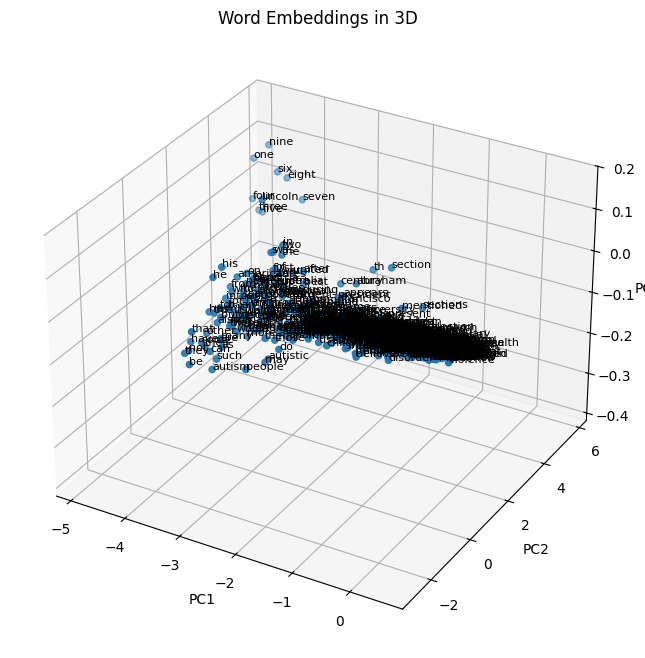

In [25]:
from sklearn.decomposition import PCA

numOfWords = 1000

weights = doc2vec_model.model.wv.vectors

print(weights.shape)  # (number of words, vector size)
import matplotlib.pyplot as plt

# Reduce vectors to 3D
pca = PCA(n_components=3)
weights_3d = pca.fit_transform(weights)

# Plot the first 1000 words in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weights_3d[:numOfWords, 0], weights_3d[:numOfWords, 1], weights_3d[:numOfWords, 2])

# Annotate points with words
words = list(doc2vec_model.model.wv.index_to_key)
for i in range(numOfWords):
    ax.text(weights_3d[i, 0], weights_3d[i, 1], weights_3d[i, 2], words[i], size=8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Word Embeddings in 3D')
plt.show()


(100, 100)


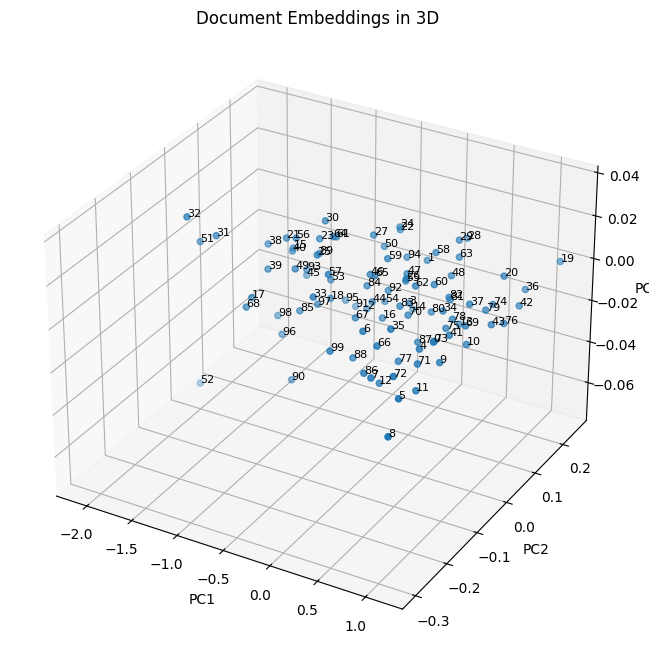

In [26]:
# Use PCA to reduce document embeddings to 3D and plot them

# Get document embeddings from doc_store
doc_embeddings = doc_store.doc_embeddings

print(doc_embeddings.shape)  # (number of documents, vector size)

# Reduce to 3D
pca = PCA(n_components=3)
doc_emb_3d = pca.fit_transform(doc_embeddings)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(doc_emb_3d[:100, 0], doc_emb_3d[:100, 1], doc_emb_3d[:100, 2])

# Annotate points with document indices
for i in range(100):
    ax.text(doc_emb_3d[i, 0], doc_emb_3d[i, 1], doc_emb_3d[i, 2], str(i), size=8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('Document Embeddings in 3D')
plt.show()

In [27]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable


# Evaluation of Vector Store Solution

Let's compare our custom vector store solution with other standard approaches to evaluate its performance.

Evaluating Custom DocumentVectorStore...
Evaluating Gensim MatrixSimilarity...
Evaluating Gensim MatrixSimilarity...

Evaluation Results:
╒════╤════════════════════════════╤═══════════════════════╤═════════════════════╤═════════════╕
│    │ Model                      │   Avg. Query Time (s) │   Memory Usage (MB) │   Precision │
╞════╪════════════════════════════╪═══════════════════════╪═════════════════════╪═════════════╡
│  0 │ Custom DocumentVectorStore │            0.00290036 │            0.038147 │         1   │
├────┼────────────────────────────┼───────────────────────┼─────────────────────┼─────────────┤
│  1 │ Gensim MatrixSimilarity    │            0.00701749 │            0.038147 │         0.3 │
╘════╧════════════════════════════╧═══════════════════════╧═════════════════════╧═════════════╛

Evaluation Results:
╒════╤════════════════════════════╤═══════════════════════╤═════════════════════╤═════════════╕
│    │ Model                      │   Avg. Query Time (s) │   Memory Usag

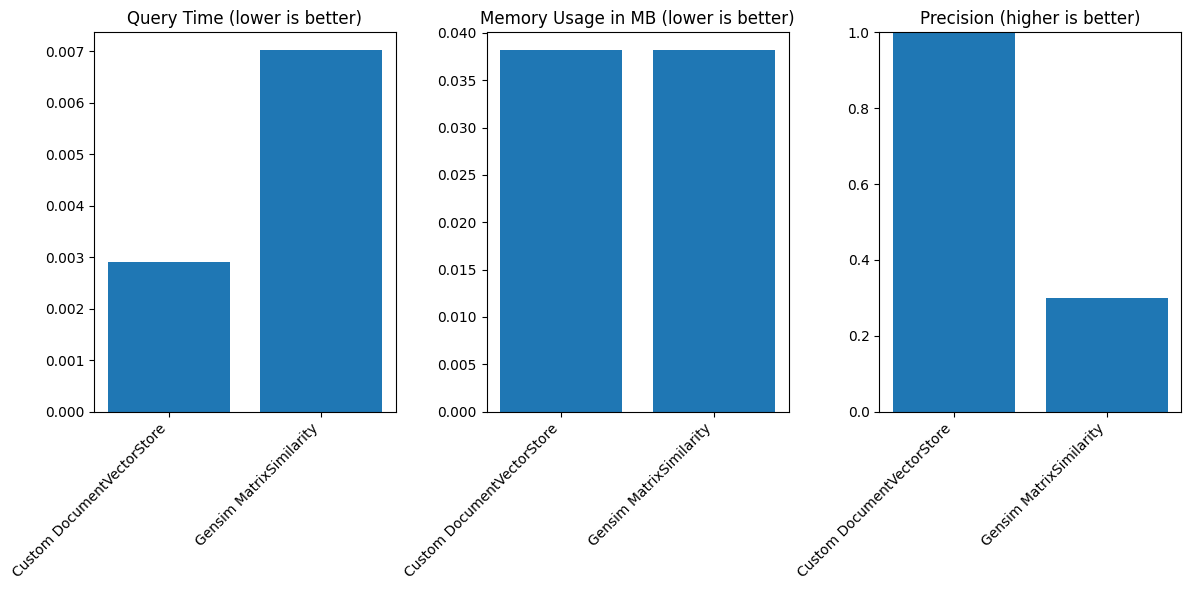


Qualitative Comparison: Sample query results
Sample query: organizations called base structures which can include exploited individuals who are not anarchists proponents include wolfi landstreicher and alfredo m ...

Results from Custom DocumentVectorStore:
Doc 5 (score: 1.0000): organizations called base structures which can include exploited individuals who are not anarchists proponents include wolfi landstreicher and alfredo m...
Doc 76 (score: 1.0000): theory public archaeology early archaeology was largely an attempt to uncover spectacular artifacts and features or to explore vast and...
Doc 42 (score: 0.9999): while decreasing the fitness of the actor this would appear to be counter intuitive if one presumes that natural selection...

Results from Gensim MatrixSimilarity:
Doc 9 (score: 5.5798): feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic...
Doc 42 (score: 5.4407): while decreasing the fitness of the a

In [28]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
from gensim.similarities import MatrixSimilarity

# -------------------------------------------------------------------
# Make sure the following variables have already been defined:
#   • sentences       (List[List[str]] of tokenized documents)
#   • doc2vec_model   (Your trained Doc2Vec wrapper)
#   • doc_store       (Your custom DocumentVectorStore instance)
#   • VECTOR_SIZE     (Dimensionality of your vectors)
# If they are defined in an earlier cell, this evaluation cell must come
# *after* that cell in the notebook.
# -------------------------------------------------------------------

# Define evaluation metrics
def evaluate_vector_stores(query_docs, test_docs, models_dict):
    """
    Evaluate different vector store implementations
    
    Parameters:
    -----------
    query_docs : list of documents to use as queries
    test_docs : complete set of documents to search in
    models_dict : dictionary of model name -> model instance
    
    Returns:
    --------
    DataFrame with evaluation results
    """
    results = []
    
    for model_name, model in models_dict.items():
        print(f"Evaluating {model_name}...")
        # Measure query time
        start_time = time.time()
        
        # Run 10 queries and average the time
        topn_results = []
        for query in query_docs[:10]:  # Use first 10 docs as queries
            if hasattr(model, 'search'):  # Our custom model
                topn = model.search(query, topn=5)
                topn_results.append([idx for idx, _ in topn])
            elif isinstance(model, MatrixSimilarity):  # Gensim's MatrixSimilarity
                # Create query vector from doc
                if hasattr(doc2vec_model.model, 'infer_vector'):  # If Doc2Vec
                    query_vec = doc2vec_model.model.infer_vector(query)
                else:  # If Word2Vec
                    vecs = [doc2vec_model.model.wv[word] for word in query if word in doc2vec_model.model.wv]
                    query_vec = np.mean(vecs, axis=0) if vecs else np.zeros(VECTOR_SIZE)
                
                sims = model[query_vec]
                topn_indices = np.argsort(-sims)[:5]
                topn_results.append(list(topn_indices))
        
        avg_query_time = (time.time() - start_time) / len(query_docs[:10])
        
        # Calculate memory usage (approximate)
        if hasattr(model, 'doc_embeddings'):  # Our custom model
            mem_usage = model.doc_embeddings.nbytes / (1024 * 1024)  # in MB
        elif isinstance(model, MatrixSimilarity):  # Gensim's MatrixSimilarity
            mem_usage = model.index.nbytes / (1024 * 1024)  # in MB
        else:
            mem_usage = -1  # Unknown
        
        # Calculate precision (for this demo, we'll use a simple metric)
        # In a real system, we'd need ground truth relevance judgments
        # Here we'll just see if the query doc itself is in the top results
        precision = 0
        for i, query_idx in enumerate(range(10)):  # First 10 docs as queries
            if query_idx in topn_results[i]:
                precision += 1
        precision = precision / 10  # Average precision
        
        results.append({
            'Model': model_name,
            'Avg. Query Time (s)': avg_query_time,
            'Memory Usage (MB)': mem_usage,
            'Precision': precision
        })
    
    return pd.DataFrame(results)

# Prepare comparison models
# 1. Our custom DocumentVectorStore
# 2. Gensim's MatrixSimilarity

# Create a MatrixSimilarity index for comparison
# Extract document vectors from doc2vec model
doc_vecs = np.array([doc2vec_model.model.dv[i] for i in range(len(sentences))])
matrix_sim = MatrixSimilarity(doc_vecs, num_features=VECTOR_SIZE)

models = {
    'Custom DocumentVectorStore': doc_store,
    'Gensim MatrixSimilarity': matrix_sim
}

# Run evaluation
eval_results = evaluate_vector_stores(sentences, sentences, models)

# Display results in a nice table
print("\nEvaluation Results:")
print(tabulate(eval_results, headers='keys', tablefmt='fancy_grid'))

# Visualize comparison
plt.figure(figsize=(12, 6))

# Query time comparison
plt.subplot(1, 3, 1)
plt.bar(eval_results['Model'], eval_results['Avg. Query Time (s)'])
plt.title('Query Time (lower is better)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Memory usage comparison
plt.subplot(1, 3, 2)
plt.bar(eval_results['Model'], eval_results['Memory Usage (MB)'])
plt.title('Memory Usage in MB (lower is better)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Precision comparison
plt.subplot(1, 3, 3)
plt.bar(eval_results['Model'], eval_results['Precision'])
plt.title('Precision (higher is better)')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplots_adjust(wspace=0.3)
plt.show()

# Qualitative comparison - show sample queries and results
print("\nQualitative Comparison: Sample query results")
sample_query = sentences[5]  # Using the 6th document as a sample query
print("Sample query:", " ".join(sample_query[:20]), "...")

print("\nResults from Custom DocumentVectorStore:")
custom_results = doc_store.search(sample_query, topn=3)
for idx, score in custom_results:
    doc_preview = " ".join(sentences[idx][:20])
    print(f"Doc {idx} (score: {score:.4f}): {doc_preview}...")

print("\nResults from Gensim MatrixSimilarity:")
# Create query vector
query_vec = doc2vec_model.model.infer_vector(sample_query)
gensim_sims = matrix_sim[query_vec]
gensim_topn = sorted(enumerate(gensim_sims), key=lambda item: -item[1])[:3]
for idx, score in gensim_topn:
    doc_preview = " ".join(sentences[idx][:20])
    print(f"Doc {idx} (score: {score:.4f}): {doc_preview}...")

# Conclusion
print("\nConclusion:")
best_query_time = eval_results.loc[eval_results['Avg. Query Time (s)'].idxmin(), 'Model']
best_memory = eval_results.loc[eval_results['Memory Usage (MB)'].idxmin(), 'Model']
best_precision = eval_results.loc[eval_results['Precision'].idxmax(), 'Model']

print(f"- Fastest queries: {best_query_time}")
print(f"- Most memory efficient: {best_memory}")
print(f"- Best precision: {best_precision}")

# Overall winner based on combined metrics
eval_results['Overall Score'] = (1/eval_results['Avg. Query Time (s)'] + 
                              1/eval_results['Memory Usage (MB)'] + 
                              eval_results['Precision']) / 3
best_overall = eval_results.loc[eval_results['Overall Score'].idxmax(), 'Model']
print(f"- Best overall performance: {best_overall}")